### Imports

In [2]:
# standard imports
import pandas as pd
import numpy as np

# models
import wrangle

###  Acquire

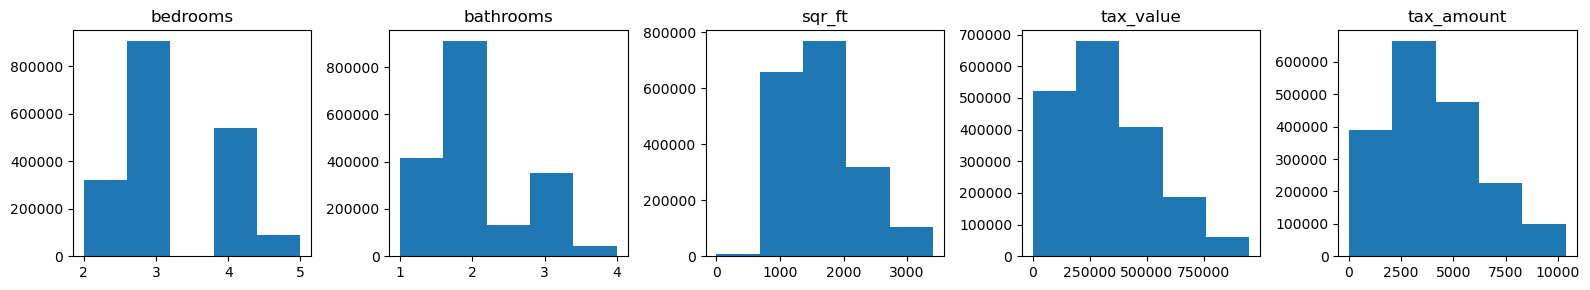

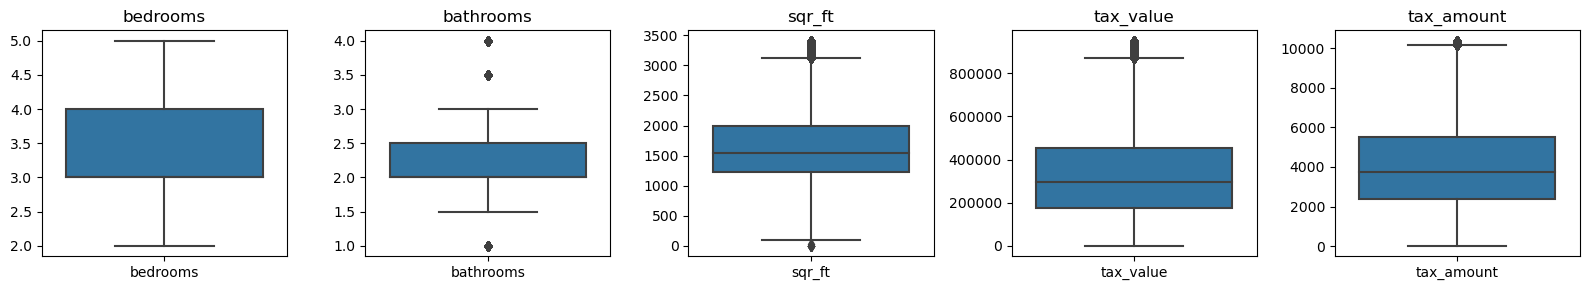

In [4]:
train, validate, test = wrangle.wrangle_zillow()

In [35]:
# inital glace at data
print('_'*50)
print(f'Data Frame: \n{train.sort_index().head(2).T.to_markdown()}')
print('_'*50)
print(f'Stats: \n{train.describe().T}')
print('_'*50)
print('Info: ')
print(train.info())
print('_'*50)
print(f'Data Types: \n{train.dtypes}')
print('_'*50)
print(f'Null Values: \n{train.isnull().sum()}')
print('_'*50)
print(f'NA Values: \n{train.isna().sum()}')

__________________________________________________
Data Frame: 
|            |        6 |        18 |
|:-----------|---------:|----------:|
| bedrooms   |      3   |      3    |
| bathrooms  |      4   |      1    |
| sqr_ft     |   1620   |   1244    |
| tax_value  | 847770   | 169471    |
| year_built |   2011   |   1950    |
| tax_amount |  10244.9 |   2532.88 |
| fips       |   6037   |   6037    |
__________________________________________________
Stats: 
                count           mean            std      min        25%  \
bedrooms    1038959.0       3.214004       0.781049     2.00       3.00   
bathrooms   1038959.0       2.053663       0.707839     1.00       2.00   
sqr_ft      1038959.0    1653.719097     564.247247     1.00    1232.00   
tax_value   1038959.0  327962.928757  198987.574520    22.00  173843.50   
year_built  1038959.0    1959.442489      20.533503  1812.00    1949.00   
tax_amount  1038959.0    4069.177134    2242.512318    20.24    2366.72   

         